# <span style = 'color:green'>**Analyzing the ElectroCardioGram (ECG) and classifying what's healthy and what's not.**</span>

## <span style = 'color:red'>**Libraries we are going to use**</span>

### <span style = 'color:blue'>**Open Powershell on your computer and run the following commands**</span>


1. pip install pandas
2. pip install matplotlib
3. pip install seaborn
4. pip install 'scikit-learn'
5. pip install jupyter notebook
6. pip install PeakUtils
7. pip install wfdb


In [13]:
import h5py # for loading data

import numpy as np # contiguous C arrays
import pandas as pd # for the dataframe object mostly

import matplotlib.pyplot as plt # for plotting graphs
import seaborn as sns # for pretty graphs

import scipy.signal as signal # for general signal processing
import peakutils # for basic peak finding utils,  provides utilities related to the detection of peaks on 1D data
import pywt # for wavelet transform bits

import wfdb # for physionet tools , for reading, writing, and processing physiologic signals and annotations.

from IPython.display import Image, IFrame
# ignore warnings so they don't bleed into the slides.
import warnings
warnings.filterwarnings('ignore')

image_defaults = {'height': 800, 'width': 600}

%matplotlib notebook

# The ECG

The ECG is the electrical signal emitted by the muscles of the heart as it goes through a three phase sequence of events.

Depolarisation and contraction of the atria, (P wave).
Depolarisation and contraction of the ventricles (QRS complex).
Repolaristion of the heart (T wave).
The electrical signal is generated by the movement of ions through specialised channels in the cell walls of the myocytes (muscle cells) in the heart. The dominant ions involved are sodium (Na+), potassium (K+) and chloride (Cl-).

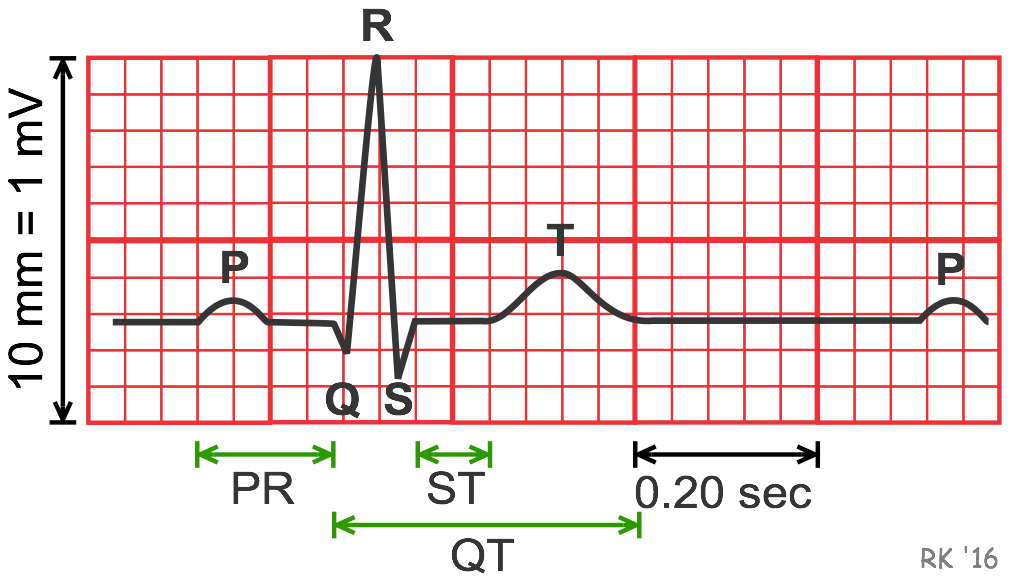

In [19]:
Image("images/ecg.png", **image_defaults)

# Normal ECG

A normal human ECG beats between 50 to 80 times a minutes at rest, at between 120 to 150 during exercise. A good sign of cardiovascular fitness is a low resting heart rate and a low maximum heart rate under exercise. 

The reasoning is fairly simple; a higher rate indicates that the heart is having to work harder to maintain normal saturation of your tissues. Some factors that determine your resting heart rate are the 

+ Size of your heart.
+ Peripheral blood pressure.
+ Weight.
+ Vasotone of your vascular beds, kidneys predominately.
+ Genetic blood disorders such as sickle cell anaemia.

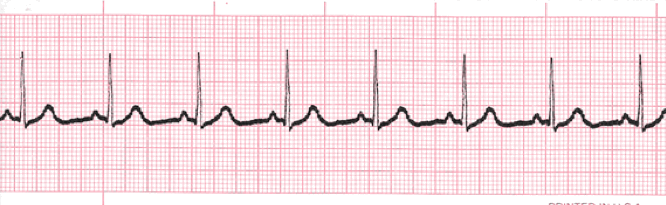

In [23]:
Image("images/ecg_normal_sinus_rhythm.png", **image_defaults)

## This is how the first ECG was recorded in 1903

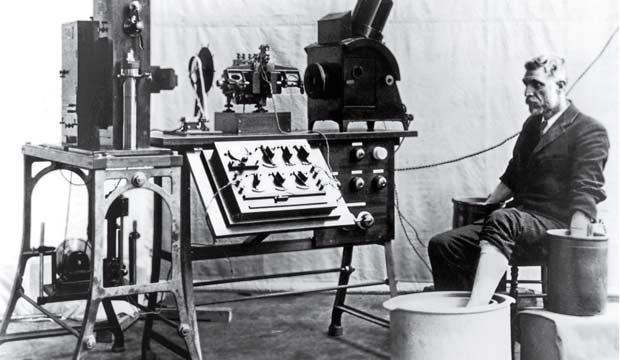

In [26]:
Image("images/willem_einthoven.jpg")

# Electrode placement

### Lead II tends to give you to characteristic shape of the ECG.

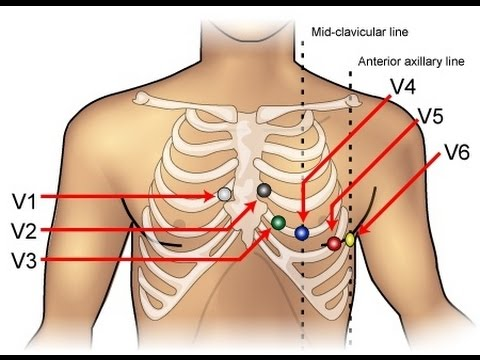

In [30]:
Image('images/ecg_lead_placement.jpg')

# Load the data

In [ ]:
h5file = h5py.File("data/emlyn_ECG_sitting_2017.04.21_11.48.30.hdf5", 'r')
dataset = h5file['RawData/Samples']
ecg_data = np.zeros((dataset.shape[0],1), dtype='d')
dataset.read_direct(ecg_data, np.s_[:], np.s_[:])

ecg_data = pd.DataFrame(data=ecg_data[500:], columns=['lead_II']) # sample 0:500, mucked

In [ ]:
fig, ax = plt.subplots()
ax.plot(ecg_data['lead_II'])

# Preprocessing signal

Signals are often noisy, the main sources of this noise:

+ Activity of other body muscles, 
+ Baseline shift because of respiration
+ Poor contact of electrodes, and equipment or electronic devices
+ Inducted electrical noise

... thus we need often need to **detrend** and **filter** the noisy signal. 

In [ ]:
data = ecg_data['lead_II'][0:2000]

# Detrend and filter - butterworth

Detrending is usually a case of removing any large baseline shifts, these are often be movement artifacts and tend to be low frequency components. Other noise, tends to be higher frequency and this can be removed by removing frequencies above what we are interested in.

Butterworth filters are traditionally used as the filter kernel, but the state of the art to denoise a signal are wavelet transformations

In [ ]:
fig, ax = plt.subplots(3, sharex=True)

# apply a butterworth filter
lowpass = 100
highpass = 0.01

a, b = signal.butter(6, (highpass, lowpass), btype='bandpass', analog=True)
filtered_signal = signal.lfilter(b, a, ecg_data['lead_II'])
smoothed_signal = signal.cspline1d(filtered_signal, lamb=1000)

ax[0].plot(ecg_data['lead_II'])
ax[1].plot(filtered_signal)
ax[2].plot(smoothed_signal)

# Detrend and filter - wavelets

Wavelets are functions that you can use to decompose signals. A Fourier transform decomposes a signal into a family of complex sinusoids, whereas a wavelet transform decomposes a signal into a family of wavelets. 

Unlike sinusoids, which are symmetric, smooth, and regular, wavelets can be either symmetric or asymmetric, sharp or smooth, regular or irregular.

To use them, you decompose your signal into a series of wavelets 

In [ ]:
single_beat = ecg_data['lead_II'][1400:2600].values

wavelets = pywt.wavedec(single_beat,'db4', level=5)

fig, ax = plt.subplots(len(wavelets)+1)

ax[0].plot(single_beat)

for i, wavelet in enumerate(wavelets):
   ax[i+1].plot(wavelet)

In [ ]:
fig, ax = plt.subplots()
ax.plot(pywt.waverec(wavelets[2:], 'db4'))